In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage import morphology, measure
from math import *
import math
import PIL.Image as image

In [2]:
def thresholding(f, L):
    # Create a new image with ones
    f_tr = np.ones(f.shape).astype(np.uint8)
    
    # Setting to 0 the pixels below the threshold
    f_tr[np.where(f < L)] = 0
    return f_tr

In [3]:
def draw_line(mat, x0, y0, x1, y1, inplace=False):
    
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('The coordinates are not valid.')
        
    if not inplace:
        mat = mat.copy()
        
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = 1
        return mat if not inplace else None
    
    # Swap axes if Y slope is smaller than X slope
    transpose = abs(x1 - x0) < abs(y1 - y0)
    if transpose:
        mat = mat.T
        x0, y0, x1, y1 = y0, x0, y1, x1
        
    # Swap line direction to go left-to-right if necessary
    if x0 > x1:
        x0, y0, x1, y1 = x1, y1, x0, y0
        
    # Write line ends
    mat[x0, y0] = 1
    mat[x1, y1] = 1
    
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    y = np.round(((y1 - y0) / (x1 - x0)) * (x - x0) + y0).astype(x.dtype)
    
    # Write intermediate coordinates
    mat[x, y] = 255
    mat[x+1, y] = 255
    mat[x-1, y] = 255
    mat[x, y+1] = 255
    mat[x, y-1] = 255
    mat[x+1, y+1] = 255
    mat[x-1, y-1] = 255
    
    if not inplace:
        return mat if not transpose else mat.T

In [4]:
def getAndRemoveNeighboors(curPixelPos, whitePixels, pixelsToBeProcessed, pixelCluster):          
        neighboors = {(curPixelPos[0]-1, curPixelPos[1]-1), (curPixelPos[0]-1, curPixelPos[1]), (curPixelPos[0]-1, curPixelPos[1]+1),
                      (curPixelPos[0], curPixelPos[1]-1),   (curPixelPos[0], curPixelPos[1]),   (curPixelPos[0], curPixelPos[1]+1),
                      (curPixelPos[0]+1, curPixelPos[1]-1), (curPixelPos[0]+1, curPixelPos[1]), (curPixelPos[0]+1, curPixelPos[1]+1)
                     }
        
        if (pixelCluster.count(curPixelPos) == 0):
            pixelCluster.append(curPixelPos)
            
        for p in neighboors:
            if p in whitePixels:
                pixelsToBeProcessed.append(p)
                pixelCluster.append(p)
                whitePixels.remove(p)
        
        return whitePixels, pixelsToBeProcessed, pixelCluster
# returns groups of adjacent white pixels

def clustering(img):
    whitePixels = set()
    recognizedClusters = []
    
    n, m = img.shape
    for x in range(n):
        for y in range(m):
            if (img[x,y] == 1):
                whitePixels.add(tuple([x,y]))
                
    while (len(whitePixels) != 0):
        pixelCluster = []
        pixelsToBeProcessed = []
        
        p = whitePixels.pop()
        pixelsToBeProcessed.append(p)
        
        while (len(pixelsToBeProcessed) != 0):
            curPixel = pixelsToBeProcessed[0]
            whitePixels, pixelsToBeProcessed, pixelCluster = getAndRemoveNeighboors(curPixel, whitePixels, pixelsToBeProcessed, pixelCluster)
            pixelsToBeProcessed.remove(curPixel)
    
        recognizedClusters.append(pixelCluster)
    
    return recognizedClusters

In [5]:
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1] 
    
def slope(x1, y1, x2, y2): # Line slope given two points:
    return (y2-y1)/(x2-x1)

def angle(s1, s2): 
    return math.degrees(math.atan((s2-s1)/(1+(s2*s1))))

# Calculate the angles between the lines that connect the 3 brightest stars (making a triangle)  
def triangle_angles(stars):
    lineA = ((stars[0][0][0], stars[0][0][1]), (stars[1][0][0], stars[1][0][1]))
    lineB = ((stars[0][0][0], stars[0][0][1]), (stars[2][0][0], stars[2][0][1]))
    lineC = ((stars[1][0][0], stars[1][0][1]), (stars[2][0][0], stars[2][0][1]))

    slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
    slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])
    slope3 = slope(lineC[0][0], lineC[0][1], lineC[1][0], lineC[1][1])

    a1 = abs(angle(slope1, slope2))
    a2 = abs(angle(slope1, slope3))
    a3 = abs(angle(slope3, slope2))

    triangle = []
    triangle.append(a1)
    triangle.append(a2)
    triangle.append(a3)
    triangle.sort()
    
    return triangle

In [6]:
def angle_show(image):
#     plt.imshow(image,cmap="gray")
    img=thresholding(image,80)
    
    
    S = clustering(img)
    stars = sorted(S, key=len)
    stars.reverse()

    # Drow the lines between the 3 brightest spots forming a triangle
    img_line = draw_line(image, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
    img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
    img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

    # Find the angles
    triangle = triangle_angles(stars)

    print(triangle)
    plt.imshow(img_line, cmap="gray");
 

In [7]:
#Database of the constellations

Constellations = {
    "Orion": [11, 25.4 ,36.45],
    "Ursa Minor": [21.2, 26.71, 47.84],
    "Ursa Major": [4, 12, 15],
    "Gemini": [13.12, 75.9, 86.6],
    "Scorpius": [16.87, 27.4, 44.3]
}

[11.325166369845586, 26.84628434625964, 38.17145071610523]


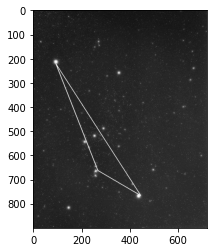

In [8]:
    
    #Add the night-sky image of the constellation 
    image=imageio.imread("Orion.jpg",as_gray=True)

    img=thresholding(image,80)
    
    
    S = clustering(img)
    stars = sorted(S, key=len)
    stars.reverse()

    # Drow the lines between the 3 brightest spots forming a triangle
    img_line = draw_line(image, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
    img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
    img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

    # Find the angles
    triangle = triangle_angles(stars)

    print(triangle)
    plt.imshow(img_line, cmap="gray");
 
  
    
        

In [9]:
def calculate_Error(triangle, expected):
    error = abs(triangle[0] - expected[0])
    error += abs(triangle[1] - expected[1])
    error += abs(triangle[2] - expected[2])
    return error/3

small_Error = 99999

for cons in Constellations:
    x = Constellations[cons]
    error = calculate_Error(triangle, x)
    if (error < small_Error):
        aux = cons
        small_Error = error

print("The constellation is predicted to be " + aux)

The constellation is predicted to be Orion


[43.75942393009737, 54.104600865402176, 82.13597520450045]


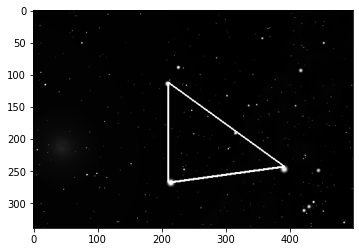

In [10]:
    #Add the night-sky image of the constellation 
    image=imageio.imread("Gemini.jpg",as_gray=True)

    img=thresholding(image,80)
    
    
    S = clustering(img)
    stars = sorted(S, key=len)
    stars.reverse()

    # Drow the lines between the 3 brightest spots forming a triangle
    img_line = draw_line(image, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
    img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
    img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

    # Find the angles
    triangle = triangle_angles(stars)

    print(triangle)
    plt.imshow(img_line, cmap="gray");

In [11]:
def calculate_Error(triangle, expected):
    error = abs(triangle[0] - expected[0])
    error += abs(triangle[1] - expected[1])
    error += abs(triangle[2] - expected[2])
    return error/3

small_Error = 99999

for cons in Constellations:
    x = Constellations[cons]
    error = calculate_Error(triangle, x)
    if (error < small_Error):
        aux = cons
        small_Error = error

print("The constellation is predicted to be " + aux)

The constellation is predicted to be Gemini


[3.527876567692906, 12.024108802689563, 15.551985370382472]


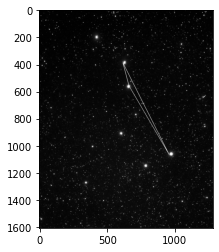

In [12]:
    #Add the night-sky image of the constellation 
    image=imageio.imread("Ursa Major.jpg",as_gray=True)

    img=thresholding(image,80)
    
    
    S = clustering(img)
    stars = sorted(S, key=len)
    stars.reverse()

    # Drow the lines between the 3 brightest spots forming a triangle
    img_line = draw_line(image, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
    img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
    img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

    # Find the angles
    triangle = triangle_angles(stars)

    print(triangle)
    plt.imshow(img_line, cmap="gray");

In [13]:
def calculate_Error(triangle, expected):
    error = abs(triangle[0] - expected[0])
    error += abs(triangle[1] - expected[1])
    error += abs(triangle[2] - expected[2])
    return error/3

small_Error = 99999

for cons in Constellations:
    x = Constellations[cons]
    error = calculate_Error(triangle, x)
    if (error < small_Error):
        aux = cons
        small_Error = error

print("The constellation is predicted to be " + aux)

The constellation is predicted to be Ursa Major


[19.271488170232043, 27.629968577075562, 46.901456747307606]


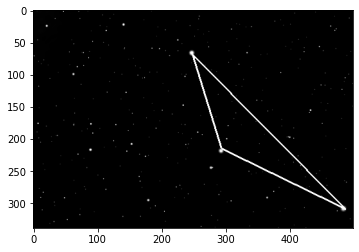

In [14]:
    #Add the night-sky image of the constellation 
    image=imageio.imread("Ursa Minor.jpg",as_gray=True)

    img=thresholding(image,80)
    
    
    S = clustering(img)
    stars = sorted(S, key=len)
    stars.reverse()

    # Drow the lines between the 3 brightest spots forming a triangle
    img_line = draw_line(image, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
    img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
    img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

    # Find the angles
    triangle = triangle_angles(stars)

    print(triangle)
    plt.imshow(img_line, cmap="gray");

In [15]:
def calculate_Error(triangle, expected):
    error = abs(triangle[0] - expected[0])
    error += abs(triangle[1] - expected[1])
    error += abs(triangle[2] - expected[2])
    return error/3

small_Error = 99999

for cons in Constellations:
    x = Constellations[cons]
    error = calculate_Error(triangle, x)
    if (error < small_Error):
        aux = cons
        small_Error = error

print("The constellation is predicted to be " + aux)

The constellation is predicted to be Ursa Minor


[15.719331847562051, 27.40125130297096, 43.12058315053301]


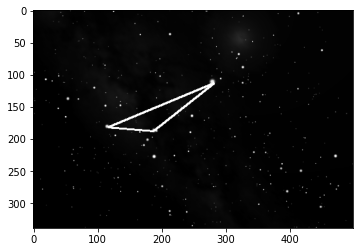

In [16]:
    #Add the night-sky image of the constellation 
    image=imageio.imread("Scorpius.jpg",as_gray=True)

    img=thresholding(image,80)
    
    
    S = clustering(img)
    stars = sorted(S, key=len)
    stars.reverse()

    # Drow the lines between the 3 brightest spots forming a triangle
    img_line = draw_line(image, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
    img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
    img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

    # Find the angles
    triangle = triangle_angles(stars)

    print(triangle)
    plt.imshow(img_line, cmap="gray");

In [17]:
def calculate_Error(triangle, expected):
    error = abs(triangle[0] - expected[0])
    error += abs(triangle[1] - expected[1])
    error += abs(triangle[2] - expected[2])
    return error/3

small_Error = 99999

for cons in Constellations:
    x = Constellations[cons]
    error = calculate_Error(triangle, x)
    if (error < small_Error):
        aux = cons
        small_Error = error

print("The constellation is predicted to be " + aux)

The constellation is predicted to be Scorpius
